# Carry Trade

In this project set I will look at the carry trade for 4 emerging market currencies and government debt. We will look at 
* South Africa
* Thailand
* Pakistan
* The Philippenes

For each country, we will create weekly positions of $10,000,000 USD in the country's debt using 5x leverage. We will borrow in GBP at 1-Month OIS plus 50bps. If the 5 year yield is less than 50bps greater than the Great Britain 5 year yield, we will not enter the trade.

## Libraries and Data Importing

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
my_api_key = "QUANDL_API_KEY"

In [2]:
ZAF_YC = quandl.get('YC/ZAF', returns="pandas",api_key=my_api_key)/100
THA_YC = quandl.get('YC/THA', returns="pandas",api_key=my_api_key)/100
PAK_YC = quandl.get('YC/PAK', returns="pandas",api_key=my_api_key)/100
PHL_YC = quandl.get('YC/PHL', returns="pandas", api_key=my_api_key)/100
GBR_5Y = quandl.get('YC/GBR5Y', returns="pandas", api_key=my_api_key)/100

UK_OIS = quandl.get('YC/GBR_ISSC',returns="pandas",api_key=my_api_key)/100

In [3]:
rate_threshold = GBR_5Y['Yield']+0.005

In [4]:
ZAF_YC = ZAF_YC.loc[:,:'3to5-Year'].asfreq('W-WED','ffill')
THA_YC = THA_YC.loc[:,:'5-Year'].asfreq('W-WED','ffill')
PAK_YC = PAK_YC.loc[:,:'5-Year'].asfreq('W-WED','ffill')
PHL_YC = PHL_YC.loc[:,:'5-Year'].asfreq('W-WED','ffill')

In [5]:
USD_ZAR = quandl.get('CUR/ZAR', returns="pandas",api_key=my_api_key).asfreq('W-WED','ffill')
USD_THB = quandl.get('CUR/THB', returns="pandas", api_key=my_api_key).asfreq('W-WED','ffill')
USD_PKR = quandl.get('CUR/PKR', returns="pandas", api_key=my_api_key).asfreq('W-WED','ffill')
USD_PHP = quandl.get('CUR/PHP', returns="pandas", api_key=my_api_key).asfreq('W-WED','ffill')
USD_GBP = quandl.get('CUR/GBP', returns="pandas",api_key=my_api_key).asfreq('W-WED','ffill')

## Functions and Calculations

In [6]:
# for each position assume 5x leverage so funding cost is nominal position*(4/5)*weekly funding rate
ois_1mo = UK_OIS.iloc[:,0].asfreq('W-WED','ffill')
funding_rate = ois_1mo + 0.005

weekly_funding_rate = funding_rate/52 # only pay for one week
weekly_funding_rate.name = 'funding_rate'

funding_rate_data = pd.DataFrame(weekly_funding_rate).join(USD_GBP)

funding_rate_data['nominal_usd'] = 8000000

funding_rate_data['nominal_GBP'] = funding_rate_data['nominal_usd']*funding_rate_data['RATE']
funding_rate_data['weekly_cost_GBP'] = funding_rate_data['nominal_GBP']*funding_rate_data['funding_rate']
funding_rate_data['prior_week_borrow_cost_usd'] = funding_rate_data['weekly_cost_GBP'].shift(1)/funding_rate_data['RATE']

weekly_borrow_cost = funding_rate_data.loc[:,'prior_week_borrow_cost_usd']

In [7]:
def prepare_spot_rates(spot_YC):
    """Convert string names to numeric tenors and pivot dataframe so each date is a column"""
    
    tenor_dict = {'1-Month':1/12,
             '3-Month':3/12,
             '6-Month':6/12,
             '9-Month':9/12,
             '12-Month':1,
             '1-Year':1,
             '2-Year':2,
             '3-Year':3,
             '4-Year':4,
             '5-Year':5,
             '3to5-Year':5}
    
    YC = spot_YC.copy()
    YC_pivot = YC.T

    YC_pivot.index = [tenor_dict[tenor] for tenor in YC_pivot.index]
    YC_pivot.index.name = 'Tenor'

    return YC_pivot

def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():
            if tenor>0.001:
                times = np.arange(tenor-0.5, 0, step=-0.5)[::-1]
                coupon_half_yr = 0.5*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_half_yr*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_half_yr))/tenor
    return zcb_rates

def bond_price(zcb, coupon_rate, tenor):
    times = np.arange(tenor, 0, step=-0.5)[::-1]
    if times.shape[0]==0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + 0.5 * coupon_rate * np.exp(-r*times).sum()
    return p


In [8]:
ZAF_zero_coupon = compute_zcb_curve(prepare_spot_rates(ZAF_YC))
THA_zero_coupon = compute_zcb_curve(prepare_spot_rates(THA_YC))
PAK_zero_coupon = compute_zcb_curve(prepare_spot_rates(PAK_YC))
PHL_zero_coupon = compute_zcb_curve(prepare_spot_rates(PHL_YC))

In [9]:
def price_bonds_weekly(zcb_long):
    
    """Price current 5 year bond and last weeks 4(51/52) bonds"""
    
    original_prices = []
    last_weeks_bond_prices = []
    coupons = []
    prior_coupons = []
    
    for i in range(0,len(zcb_long)):
        rates = zcb_long.iloc[i,:]

        # price new 5 year bond
        coupon = zcb_long.iloc[i,len(zcb_long.columns)-1] # last column corrisponds to 5 year rate
        original_px = bond_price(zcb=rates,coupon_rate = coupon,tenor=5)

        # price last weeks bond as a 4(51/52) bond
        prior_coupon = zcb_long.shift(1).iloc[i,len(zcb_long.columns)-1] # last column corrisponds to 5 year rate
        new_px = bond_price(zcb=rates,coupon_rate = prior_coupon,tenor=4+(51/52))
        
        coupons.append(coupon)
        prior_coupons.append(prior_coupon)
        original_prices.append(original_px)
        last_weeks_bond_prices.append(new_px)

    bond_prices = pd.DataFrame({'original_5y':coupons,
                                'original_price':original_prices,
                                'prior_5y':prior_coupons,
                                'last_week_bond_new_price':last_weeks_bond_prices},
                               index=zcb_long.index)

    bond_prices['price_change_home'] = bond_prices['last_week_bond_new_price']-bond_prices['original_price'].shift(1)
    
    return bond_prices    

In [10]:
def find_nominal_positions(bond_df, rate_threshold):

    bonds_and_rates = bond_df.join(rate_threshold)
    bonds_and_rates.loc[bonds_and_rates['original_5y'] > bonds_and_rates['Yield'],'nominal_position_usd'] = 10000000
    bonds_and_rates.loc[bonds_and_rates['original_5y'] <= bonds_and_rates['Yield'],'nominal_position_usd'] = 0

    return bonds_and_rates.loc[:,['original_price','last_week_bond_new_price','price_change_home','nominal_position_usd']]

In [11]:
ZAF_bonds = find_nominal_positions(price_bonds_weekly(ZAF_zero_coupon.T),rate_threshold)
THA_bonds = find_nominal_positions(price_bonds_weekly(THA_zero_coupon.T),rate_threshold)
PAK_bonds = find_nominal_positions(price_bonds_weekly(PAK_zero_coupon.T),rate_threshold)
PHL_bonds = find_nominal_positions(price_bonds_weekly(PHL_zero_coupon.T),rate_threshold)

In [12]:
def position_PnL(bond_prices,exchange_rate, weekly_funding_cost):
    """Take bond prices, exchange rates, and calculate P&L for weekly positions and nominal usd value"""
    bond_df = bond_prices.copy()
    bond_df = bond_df.join(exchange_rate)
    bond_df = bond_df.join(weekly_funding_cost)
    bond_df['prior_nominal_position_usd'] = bond_df['nominal_position_usd'].shift(1)
    bond_df['nominal_position_home'] = bond_df['nominal_position_usd']*bond_df['RATE']
    bond_df['last_week_nominal_position_usd'] = bond_df['nominal_position_home'].shift(1)/bond_df['RATE']
    bond_df['currency_P_L'] = bond_df['last_week_nominal_position_usd']-bond_df['nominal_position_usd'].shift(1)
    bond_df['purchase_quantity'] = bond_df['nominal_position_home']/bond_df['original_price']
    bond_df['prior_week_quantity'] = bond_df['purchase_quantity'].shift(1)
    bond_df['last_week_position_value_home'] = bond_df['prior_week_quantity']*bond_df['last_week_bond_new_price']
    bond_df['last_week_position_value_usd'] = bond_df['last_week_position_value_home']/bond_df['RATE']
    bond_df['usd_P_L'] = bond_df['last_week_position_value_usd'] - bond_df['nominal_position_usd'].shift(1)
    bond_df['bond_P_L'] = bond_df['usd_P_L']-bond_df['currency_P_L']
    bond_df.loc[bond_df['prior_nominal_position_usd']>0,'funding_cost'] = bond_df['prior_week_borrow_cost_usd']
    bond_df.loc[bond_df['prior_nominal_position_usd']==0,'funding_cost'] = 0
    bond_df['strategy_P_L'] = bond_df['usd_P_L']-bond_df['funding_cost']
    
    PnL_fields = bond_df.loc[:,['nominal_position_usd','strategy_P_L','usd_P_L','currency_P_L', 'bond_P_L','funding_cost']]
    
    return PnL_fields

In [13]:
ZAF_PnL = position_PnL(ZAF_bonds,exchange_rate=USD_ZAR, weekly_funding_cost = weekly_borrow_cost).dropna()
THA_PnL = position_PnL(THA_bonds, exchange_rate=USD_THB, weekly_funding_cost = weekly_borrow_cost).dropna()
PAK_PnL = position_PnL(PAK_bonds, exchange_rate=USD_PKR, weekly_funding_cost = weekly_borrow_cost).dropna()
PHL_PnL = position_PnL(bond_prices=PHL_bonds,exchange_rate=USD_PHP, weekly_funding_cost = weekly_borrow_cost).dropna()

## Strategy Analysis

### South Africa Strategy

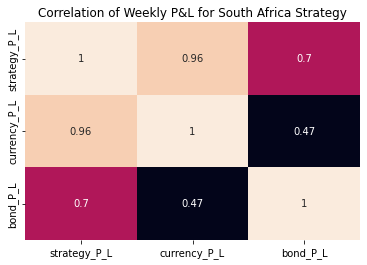

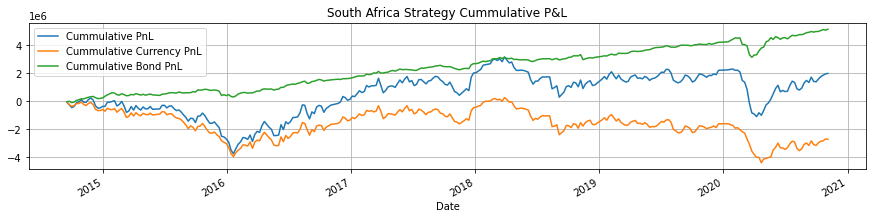

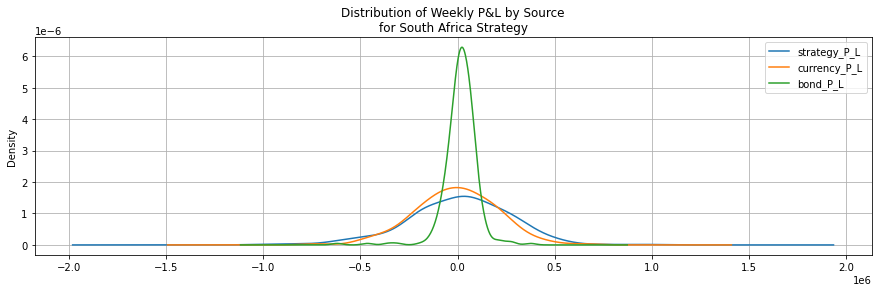

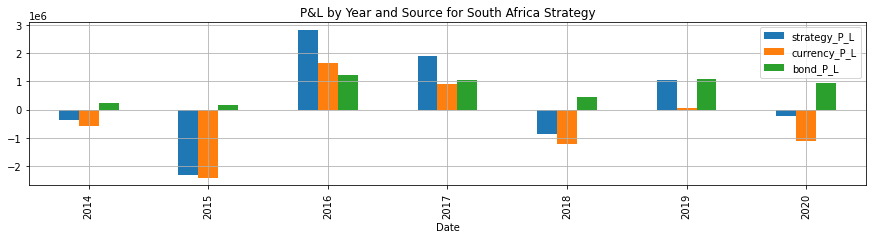

In [14]:
ZAF_corr = ZAF_PnL[['strategy_P_L',
         'currency_P_L',
         'bond_P_L']].corr()
plt.plot()
sns.heatmap(ZAF_corr, annot=True,cbar=False)
plt.title('Correlation of Weekly P&L for South Africa Strategy')
plt.show()

ZAF_PnL['Cummulative PnL'] = ZAF_PnL['strategy_P_L'].cumsum()
ZAF_PnL['Cummulative Currency PnL'] = ZAF_PnL['currency_P_L'].cumsum()
ZAF_PnL['Cummulative Bond PnL'] = ZAF_PnL['bond_P_L'].cumsum()
ZAF_PnL['Cummulative PnL'].plot(title='South Africa Strategy Cummulative P&L', grid=True,legend=True,figsize=(15,3));
ZAF_PnL['Cummulative Currency PnL'].plot(title='South Africa Strategy Cummulative P&L', grid=True, legend=True);
ZAF_PnL['Cummulative Bond PnL'].plot(title='South Africa Strategy Cummulative P&L', grid=True, legend=True);

ZAF_PnL[['strategy_P_L',
         'currency_P_L',
         'bond_P_L']].plot.kde(figsize=(15,4),
                               title = 'Distribution of Weekly P&L by Source\nfor South Africa Strategy',
                              grid=True);

ZAF_PnL[
    ['strategy_P_L','currency_P_L','bond_P_L']
].groupby(ZAF_PnL.index.year).sum().plot.bar(figsize=(15,3),
                                             title='P&L by Year and Source for South Africa Strategy',grid=True);

The carry return on South African government debt looks to provide strong and steady returns. Unfortunately, that us paired with some heavy currency losses. Specifically, in 2015, 2018, and 2020. The majority of the volatility in the strategy comes from the currency and not the debt security as evident by the distribution of weekly P&L chart. The correlation of weekly currency P&L and Debt P&L is high but that doesn't factor in the magnitude of the P&L. 

### Pakistan Strategy

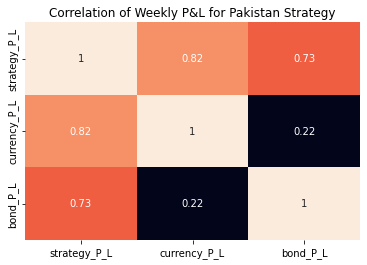

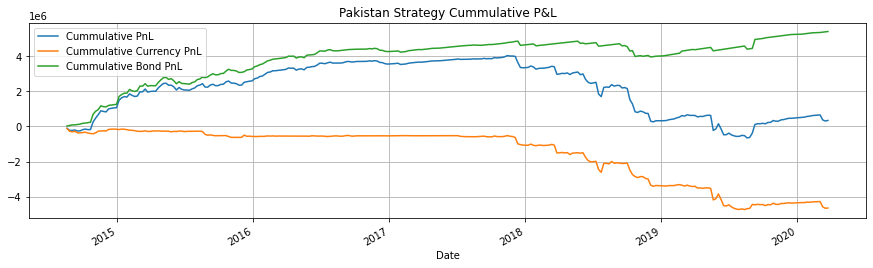

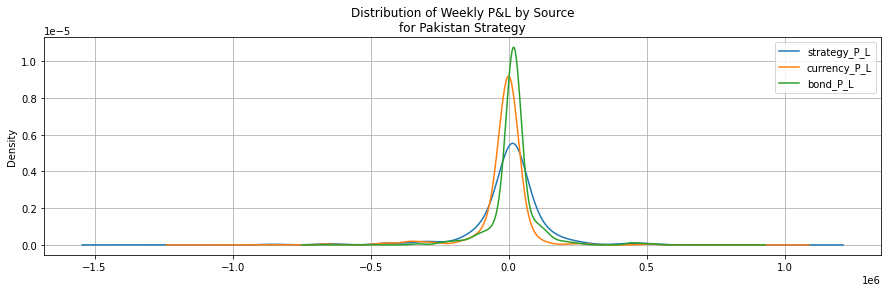

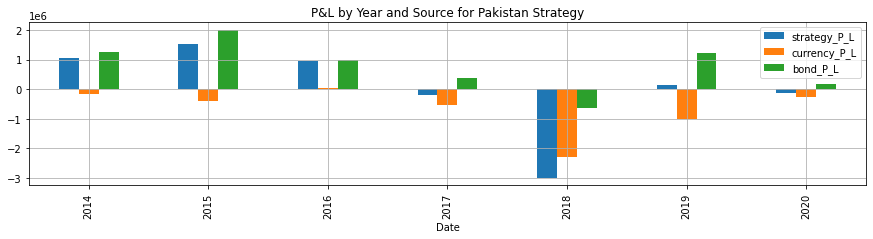

In [15]:
PAK_corr = PAK_PnL[['strategy_P_L',
         'currency_P_L',
         'bond_P_L']].corr()
plt.plot()
sns.heatmap(PAK_corr, annot=True,cbar=False)
plt.title('Correlation of Weekly P&L for Pakistan Strategy')
plt.show()

PAK_PnL['Cummulative PnL'] = PAK_PnL['strategy_P_L'].cumsum()
PAK_PnL['Cummulative Currency PnL'] = PAK_PnL['currency_P_L'].cumsum()
PAK_PnL['Cummulative Bond PnL'] = PAK_PnL['bond_P_L'].cumsum()
PAK_PnL['Cummulative PnL'].plot(title='Pakistan Strategy Cummulative P&L', grid=True,legend=True,figsize=(15,4));
PAK_PnL['Cummulative Currency PnL'].plot(title='Pakistan Strategy Cummulative P&L', grid=True, legend=True);
PAK_PnL['Cummulative Bond PnL'].plot(title='Pakistan Strategy Cummulative P&L', grid=True, legend=True);

PAK_PnL[['strategy_P_L',
         'currency_P_L',
         'bond_P_L']].plot.kde(figsize=(15,4),
                               title = 'Distribution of Weekly P&L by Source\nfor Pakistan Strategy',
                              grid=True);

PAK_PnL[
    ['strategy_P_L','currency_P_L','bond_P_L']
].groupby(PAK_PnL.index.year).sum().plot.bar(figsize=(15,3),title='P&L by Year and Source for Pakistan Strategy',grid=True);

The carry return on Pakistani government debt provided strong and steady returns from 2014-2017 but slowed in the latter part of our time window. That is paired with heavy currency losses from 2018 until the series stopped in March 2020. The volatility in the strategy comes from both the debt and currency. The correlation of weekly currency P&L and Debt P&L is relatively low which explains why the distribution of weekly strategy P&L is wider than currency P&L and the bond P&L alone. I suspect geopolitical issues to be a cause of some of the pour performance in this strategy.

### Thailand Strategy

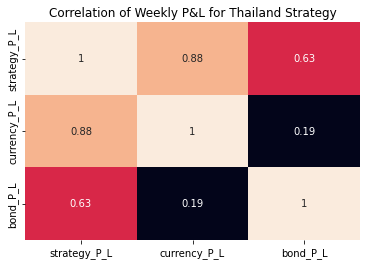

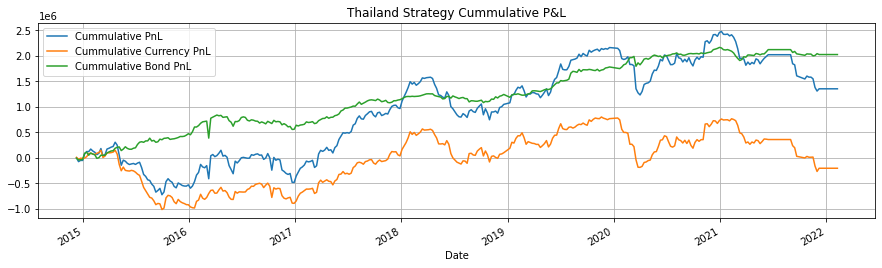

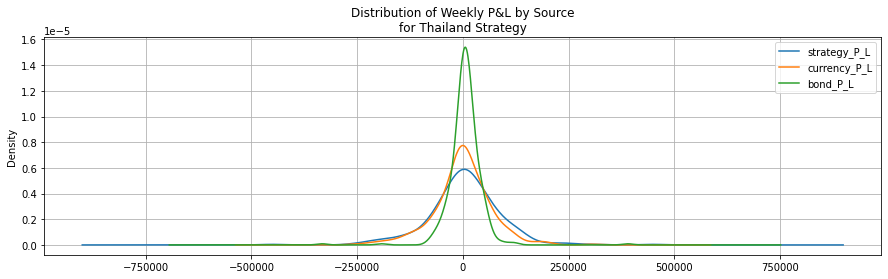

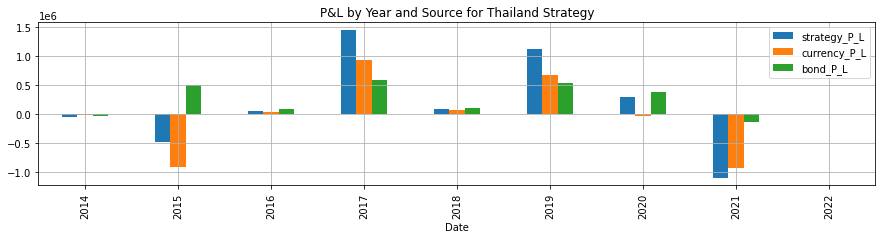

In [16]:
THA_corr = THA_PnL[['strategy_P_L',
         'currency_P_L',
         'bond_P_L']].corr()
plt.plot()
sns.heatmap(THA_corr, annot=True,cbar=False)
plt.title('Correlation of Weekly P&L for Thailand Strategy')
plt.show()

THA_PnL['Cummulative PnL'] = THA_PnL['strategy_P_L'].cumsum()
THA_PnL['Cummulative Currency PnL'] = THA_PnL['currency_P_L'].cumsum()
THA_PnL['Cummulative Bond PnL'] = THA_PnL['bond_P_L'].cumsum()
THA_PnL['Cummulative PnL'].plot(title='Thailand Strategy Cummulative P&L', grid=True,legend=True,figsize=(15,4));
THA_PnL['Cummulative Currency PnL'].plot(title='Thailand Strategy Cummulative P&L', grid=True, legend=True);
THA_PnL['Cummulative Bond PnL'].plot(title='Thailand Strategy Cummulative P&L', grid=True, legend=True);

THA_PnL[['strategy_P_L',
         'currency_P_L',
         'bond_P_L']].plot.kde(figsize=(15,4),
                               title = 'Distribution of Weekly P&L by Source\nfor Thailand Strategy',
                              grid=True);

THA_PnL[
    ['strategy_P_L','currency_P_L','bond_P_L']
].groupby(THA_PnL.index.year).sum().plot.bar(figsize=(15,3),title='P&L by Year and Source for Thailand Strategy',grid=True);

The carry return on Thailand's government debt looks to provide steady returns although not as much as South Africa and Pakistan. On the bright side, The Baht has performed much better than the Pakistani Rupee and South African Rand. The currency has some rough times in 2015 and 2021, but ends up close to breaking even for our time window. Like South Africa, the majority of the volatility comes from the currency, but this time the currency is not trending in a negative direction. The correlation of weekly currency P&L and Debt P&L is relatively low which explains why the distribution of weekly strategy P&L is wider than currency P&L and the bond P&L alone.

### Philippenes Strategy

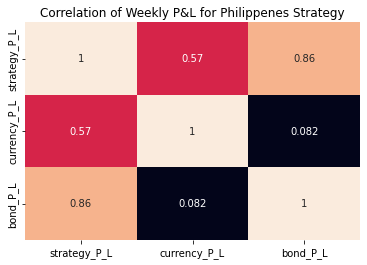

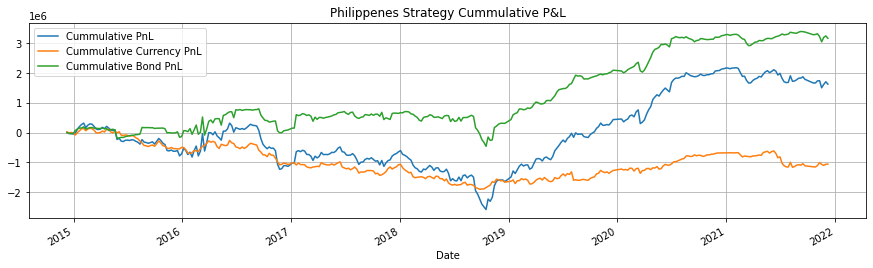

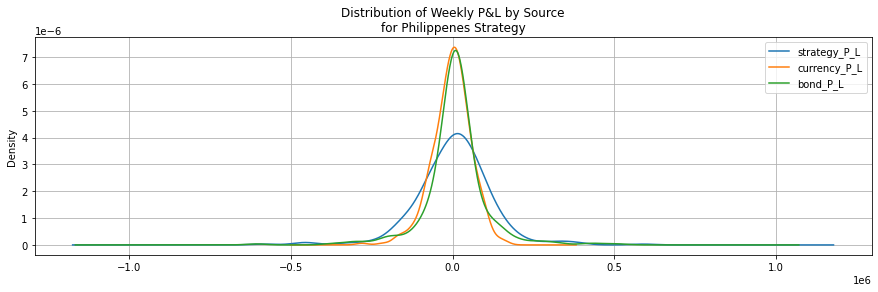

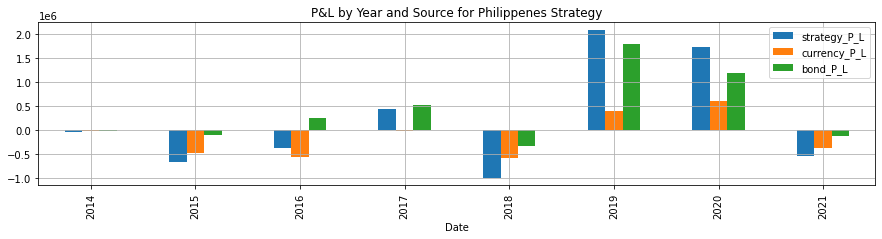

In [17]:
PHL_corr = PHL_PnL[['strategy_P_L',
         'currency_P_L',
         'bond_P_L']].corr()

plt.plot()
sns.heatmap(PHL_corr, annot=True,cbar=False)
plt.title('Correlation of Weekly P&L for Philippenes Strategy')
plt.show()

PHL_PnL['Cummulative PnL'] = PHL_PnL['strategy_P_L'].cumsum()
PHL_PnL['Cummulative Currency PnL'] = PHL_PnL['currency_P_L'].cumsum()
PHL_PnL['Cummulative Bond PnL'] = PHL_PnL['bond_P_L'].cumsum()
PHL_PnL['Cummulative PnL'].plot(title='Philippenes Strategy Cummulative P&L', grid=True,legend=True,figsize=(15,4));
PHL_PnL['Cummulative Currency PnL'].plot(title='Philippenes Strategy Cummulative P&L', grid=True, legend=True);
PHL_PnL['Cummulative Bond PnL'].plot(title='Philippenes Strategy Cummulative P&L', grid=True, legend=True);

PHL_PnL[['strategy_P_L',
         'currency_P_L',
         'bond_P_L']].plot.kde(figsize=(15,4),
                               title = 'Distribution of Weekly P&L by Source\nfor Philippenes Strategy',
                              grid=True);

PHL_PnL[
    ['strategy_P_L','currency_P_L','bond_P_L']
].groupby(PHL_PnL.index.year).sum().plot.bar(figsize=(15,3),
                                             title='P&L by Year and Source for Philippenes Strategy',grid=True);

The carry return on The Philippenes government debt looks to provide relatively strong and steady returns. The currency suffered steady declines from 2015 through 2018 and has been relatively steady since. The volatility in the strategy comes from both the debt and currency, but they have almost no correlation to eachother. The debt produced little gains from 2015 through 2018 when the currency was declining but has been producing solid returns since. If we started out analysis in 2019, this would be the best performing strategy.

### Summary

While some of these strategies performed well on their own, they each experience time periods where they struggled and the other currencies did not. A diversified basket of all the strategies along with potential others would reduce volatility from country specific risks. Obviously, the diversified basket would still struggle in systemic events like a grobal pandemic, but volatility would be reduced.